### Introduction
In this notebook, I work with Kaggle's dataset on [house prices](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) which includes 80 features and an id column with final sales occurring from 2006 to 2010 in Ames, Iowa.  The goal of this notebook is to predict the final sale price of the home using linear regression models.  I achieve this by identifying the most valuable features, feature engineering, and applying different types of linear regression models (e.g. OLS, Lasso, Ridge, and ElasticNet).  Lastly, I integrate external information, namely, mortgage rates and average median in Ames, to see if economic information can help improve the models.

### 1 - Load the Data
With 81 columns, this dataset packs a lot into it!  Things to note are that there are 38 numerical columns and 43 categorical columns.  In addition, some of the features have missing values, one of which has 95% missing! 

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
from tabulate import tabulate
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

C:\Users\Crystal\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array
C:\Users\Crystal\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
df = pd.read_csv('houseprices.cvs')

In [3]:
df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

### 2 - Data Exploration and Cleaning
This section is split into three parts:  the target variable, other numerical features, and categorical features.

#### 2.1 - The Target Variable
Since there are no missing values in the target variable, I will jump straight into examining the sales price graphically.  A histogram and boxplot of sale prices are shown below.  Both indicate that sale prices are right skewed, with medians sale prices at ~\$150k.  The boxplot pegs sale prices above ~\$350k as outliers, which is consistent with what I see in the histogram.  To get a sense of how many outliers there are, I used Tukey's method with a threshold of 1.5 and found there are 61 outliers which is about 4% of the data.  

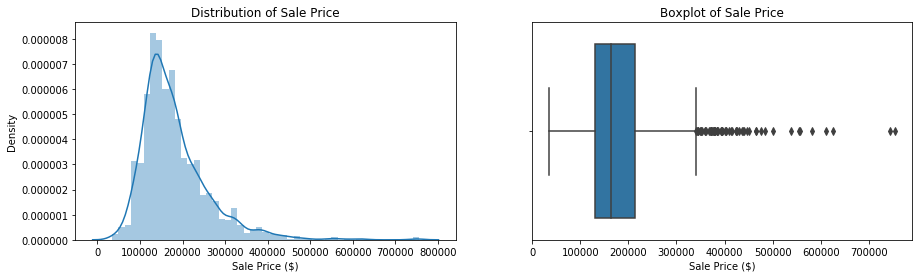

In [5]:
fig, (axis1, axis2) = plt.subplots(1,2, figsize = (15,4))

sns.distplot(df['saleprice'], ax = axis1)
sns.boxplot(x = 'saleprice', data = df, ax = axis2)

axis1.set_title('Distribution of Sale Price')
axis2.set_title('Boxplot of Sale Price')
for ax in [axis1, axis2]:
    ax.set_xlabel('Sale Price ($)')
axis1.set_ylabel('Density')

In [6]:
saleprice_q75, saleprice_q25 = np.percentile(df['saleprice'], [75, 25])
saleprice_iqr = saleprice_q75 - saleprice_q25

saleprice_minval = saleprice_q25 - (saleprice_iqr * 1.5)
saleprice_maxval = saleprice_q75 + (saleprice_iqr * 1.5)

print('The number of outliers is {}'.format(len(np.where((df['saleprice'] > saleprice_maxval) | (df['saleprice'] < saleprice_minval))[0])))

The number of outliers is 61


** What can we do about the skew?**  
One way to deal with skewed distributions is to transform the data.  In this case, taking the log of the sale price creates a more normally distributed histogram. The boxplot shows there are still outliers, but according to Tukey's method, the number of outliers has decreased from 61 to 28, about 2% of the total data.  These outliers I will remove.  

In [7]:
df['log_saleprice'] = np.log(df['saleprice'])

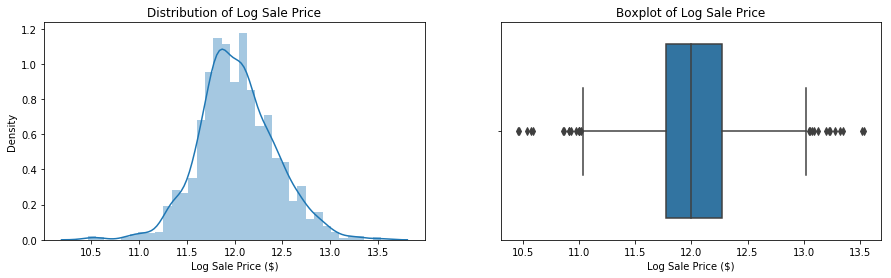

In [8]:
fig, (axis1, axis2) = plt.subplots(1,2, figsize = (15,4))

sns.distplot(df['log_saleprice'], ax = axis1)
sns.boxplot(x = 'log_saleprice', data = df, ax = axis2)

axis1.set_title('Distribution of Log Sale Price')
axis2.set_title('Boxplot of Log Sale Price')
for ax in [axis1, axis2]:
    ax.set_xlabel('Log Sale Price ($)')
axis1.set_ylabel('Density')

In [9]:
log_saleprice_q75, log_saleprice_q25 = np.percentile(df['log_saleprice'], [75, 25])
log_saleprice_iqr = log_saleprice_q75 - log_saleprice_q25

log_saleprice_minval = log_saleprice_q25 - (log_saleprice_iqr * 1.5)
log_saleprice_maxval = log_saleprice_q75 + (log_saleprice_iqr * 1.5)

print('The number of outliers is {}'.format(len(np.where((df['log_saleprice'] > log_saleprice_maxval) | (df['log_saleprice'] < log_saleprice_minval))[0])))

The number of outliers is 28


In [10]:
df2 = df[(df['log_saleprice'] >= log_saleprice_minval) & (df['log_saleprice'] <= log_saleprice_maxval)]

In [11]:
df2.drop('saleprice', axis = 1, inplace = True)

#### 2.2 - Numerical Features
With 37 numerical features (I discarded the id column), is there a way to figure out which ones to focus on? One way to choose important features is to look at a correlation matrix and see which features are correlated with the target variable. In this case, I've plotted the absolute value of the correlation to make it easier to find which features have higher correlation.

In [12]:
num_col = [col for col in df2.columns if df2[col].dtype == 'float64' or df2[col].dtype == 'int64' ]

In [13]:
# Remove id column
num_col = num_col[1:]

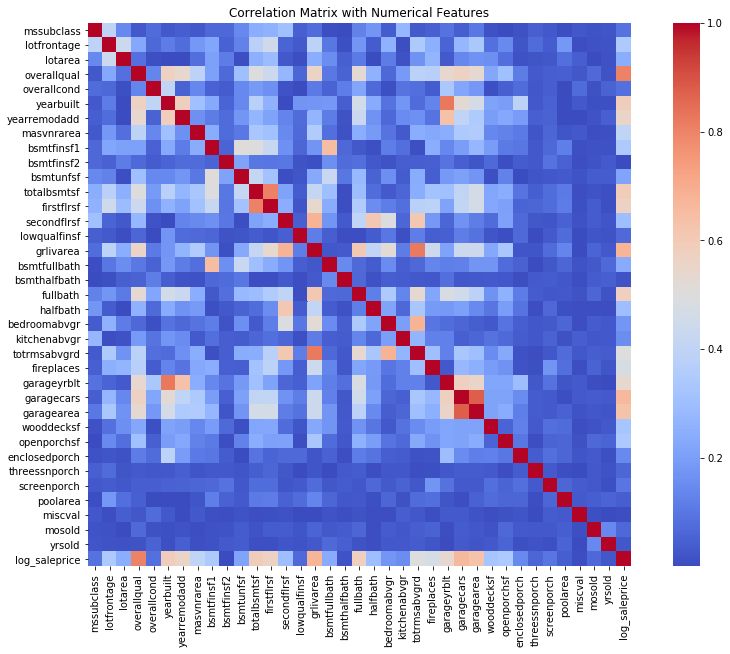

In [14]:
fig, axis1 = plt.subplots(1,1, figsize = (15,10))
sns.heatmap(np.absolute(df2[num_col].corr()), square = True, cmap = 'coolwarm', ax = axis1)
plt.title('Correlation Matrix with Numerical Features')

Features to focus on are some shade of red along the last row of the correlation matrix (i.e.  features that are correlated with 'log_saleprice').  In this case, it seems like the numeric features that are correlated with 'saleprice' are 'overallqual, 'yearbuilt', 'yearremodadd', 'totalbsmtsf', 'firstflrsf', 'grlivarea', 'fullbath', 'totrmsabvgrd', 'fireplaces', 'garageyrblt', 'garagecars', and 'garagearea'.  


In [15]:
num_important = ['overallqual', 'yearbuilt', 'yearremodadd', 'totalbsmtsf', 'firstflrsf', 
                 'grlivarea', 'fullbath', 'totrmsabvgrd', 'fireplaces', 'garageyrblt', 'garagecars', 'garagearea'] 

Of these important numeric features, two of them have missing values.  I will now go through each of these features to perform exploratory data analysis and deal with missing values.  

In [16]:
for col in num_important:
    if df2[col].isnull().sum() > 0:
        print(col)

garageyrblt


##### 2.2.1 - Overall Quality
The overall quality is a number between 1 and 10, where 1 is very poor and 10 is very excellent.  Most of the homes have a rating of 5 or 6; that is to say, the houses are of average quality.  A scatterplot shows that as the quality increases, the log of sale prices also increases.  

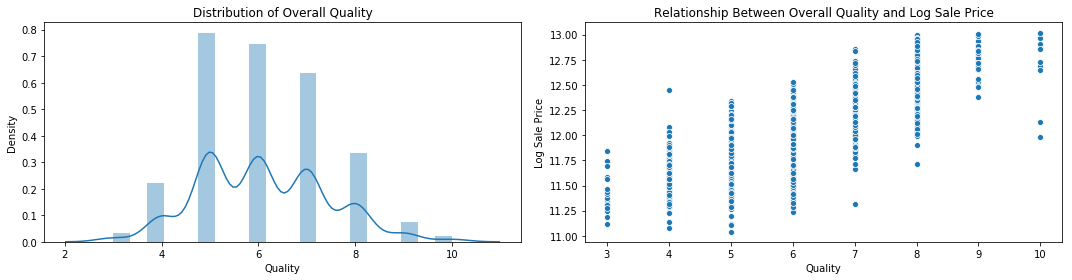

In [17]:
fig, (axis1, axis2) = plt.subplots(1,2, figsize = (15,4))

sns.distplot(df2['overallqual'], ax = axis1)
sns.scatterplot(x = 'overallqual', y = 'log_saleprice', data = df2, ax = axis2)

axis1.set_title('Distribution of Overall Quality')
axis2.set_title('Relationship Between Overall Quality and Log Sale Price')

axis1.set_ylabel('Density')
axis1.set_xlabel('Quality')

axis2.set_ylabel('Log Sale Price')
axis2.set_xlabel('Quality')
plt.tight_layout()

##### 2.2.2 - Year Built
Houses in this dataset were built anywhere between 1872 to 2010.  Most of the houses were built after 2000, although there are 17 houses built before 1900.  These houses seem pretty old, but it isn't unheard of, depending on where the house is located.  Sale prices seem steady until 1970, which then sees a general increase in price.  

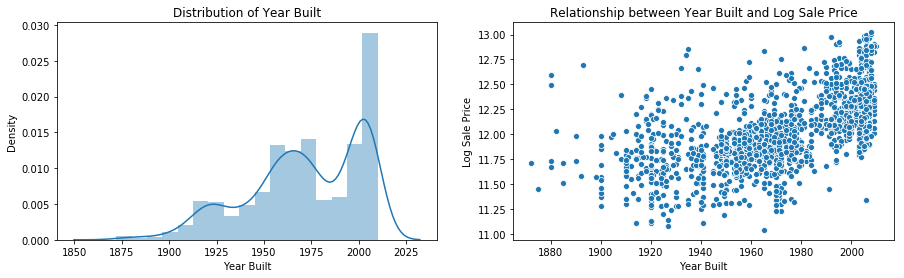

In [18]:
fig, (axis1, axis2) = plt.subplots(1,2, figsize = (15,4))

sns.distplot(df2['yearbuilt'], ax = axis1)
sns.scatterplot(x = 'yearbuilt', y = 'log_saleprice', data = df2, ax = axis2)

axis1.set_xlabel('Year Built')
axis2.set_xlabel('Year Built')

axis1.set_ylabel('Density')
axis2.set_ylabel('Log Sale Price')

axis1.set_title("Distribution of Year Built")
axis2.set_title("Relationship between Year Built and Log Sale Price")

In [19]:
print('Oldest house(s) for sale was built in: {}'.format(df2['yearbuilt'].min()))
print('Newest houses for sale were built in: {}'.format(df2['yearbuilt'].max()))

Oldest house(s) for sale was built in: 1872
Newest houses for sale were built in: 2010


##### 2.2.3 - Year Remodeled
This is the year a house has been remodeled.  If the house has never been remodeled, then the year it was built is inserted.  The histogram for the remodeled year is quite different from the histogram of the year built.  In this case, all houses were remodeled or built at 1950.  There appears to be a faint increase in sale price as time goes on, but the trend is not as strong as the trend seen in year built (section 2.2.2).

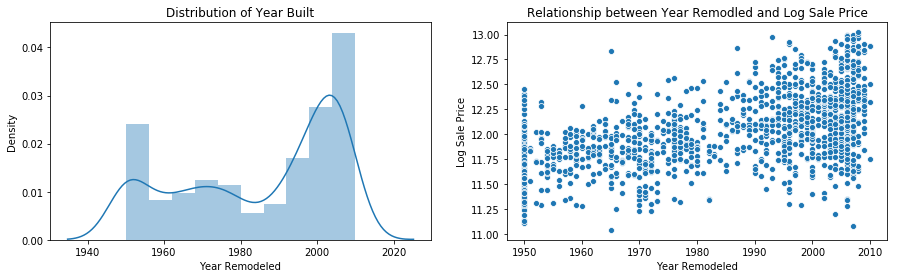

In [20]:
fig, (axis1, axis2) = plt.subplots(1,2, figsize = (15,4))

sns.distplot(df2['yearremodadd'], ax = axis1)
sns.scatterplot(x = 'yearremodadd', y = 'log_saleprice', data = df2, ax = axis2)

axis1.set_xlabel('Year Remodeled')
axis2.set_xlabel('Year Remodeled')

axis1.set_ylabel('Density')
axis2.set_ylabel('Log Sale Price')

axis1.set_title("Distribution of Year Built")
axis2.set_title("Relationship between Year Remodled and Log Sale Price")

In [21]:
print('Oldest remodeled house was in: {}'.format(df2['yearremodadd'].min()))
print('Newest remodeled house was in: {}'.format(df2['yearremodadd'].max()))

Oldest remodeled house was in: 1950
Newest remodeled house was in: 2010


##### 2.2.4 - Living Space Square Footage
There are three features that I've deemed are living spaces and involve square footages:  the total basement square footage, the first floor square footage, and above ground living area square footage.  Below are the distributions for the basement, first floor, and above ground square footages.  

For the distribution of basement square footage, there are two peaks, one at 0 to indicate there is no basement, and another peak at ~1000.  The distribution for first floor also has a peak at ~1000, but the distribution for above ground area has a peak closer to 2000.  All three distributions are heavily right skewed.  

As for log sale prices, the general trend is that as square footages increases, the price also increases.  

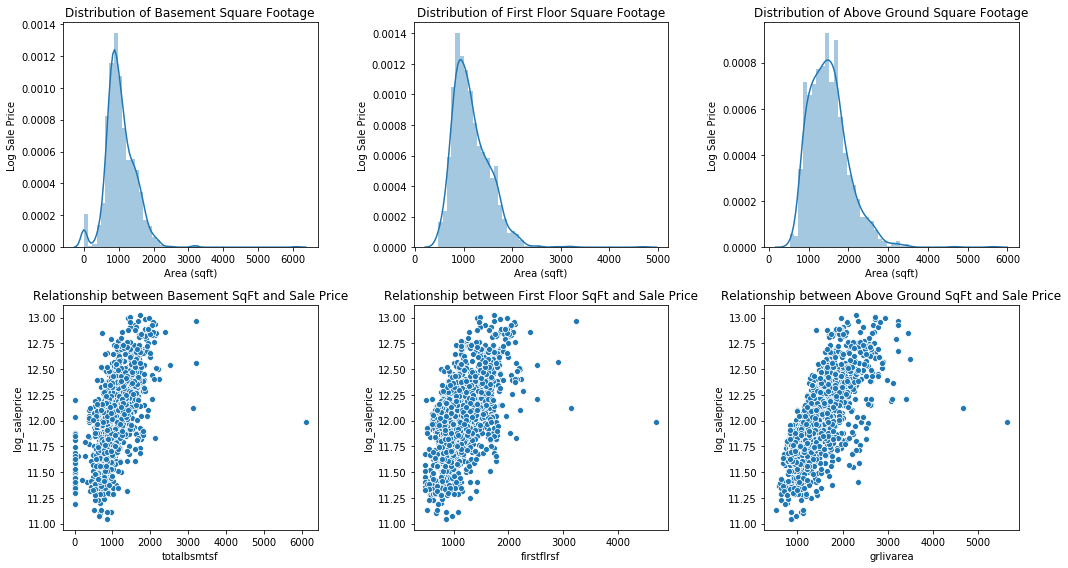

In [22]:
fig, ((axis1, axis2, axis3), (axis4, axis5, axis6)) = plt.subplots(2,3, figsize = (15,8))

sns.distplot(df2['totalbsmtsf'], ax = axis1)
sns.distplot(df2['firstflrsf'], ax = axis2)
sns.distplot(df2['grlivarea'], ax = axis3)
sns.scatterplot(x = 'totalbsmtsf', y = 'log_saleprice', data = df2, ax = axis4)
sns.scatterplot(x = 'firstflrsf', y = 'log_saleprice', data = df2, ax = axis5)
sns.scatterplot(x = 'grlivarea', y = 'log_saleprice', data = df2, ax = axis6)

axis1.set_title('Distribution of Basement Square Footage')
axis2.set_title('Distribution of First Floor Square Footage')
axis3.set_title('Distribution of Above Ground Square Footage')
axis4.set_title('Relationship between Basement SqFt and Sale Price')
axis5.set_title('Relationship between First Floor SqFt and Sale Price')
axis6.set_title('Relationship between Above Ground SqFt and Sale Price')

for ax in [axis1, axis2, axis3]:
    ax.set_xlabel('Area (sqft)')
    ax.set_ylabel('Density')

for ax in [axis1, axis2, axis3]:
    ax.set_xlabel('Area (sqft)')
    ax.set_ylabel('Log Sale Price')
    
plt.tight_layout()

##### 2.2.5 - Full Bath
The number of full baths is a range between 0-3, with most of the houses having either 1 or 2 baths.  There is a general trend that with more bathrooms, the higher the price. 

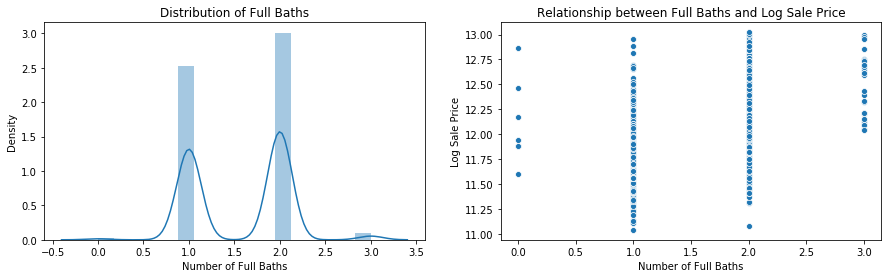

In [23]:
fig, (axis1, axis2) = plt.subplots(1,2, figsize = (15,4))

sns.distplot(df2['fullbath'], ax = axis1)
sns.scatterplot(x = 'fullbath', y = 'log_saleprice', data = df2, ax = axis2)

axis1.set_xlabel('Number of Full Baths')
axis2.set_xlabel('Number of Full Baths')

axis1.set_ylabel('Density')
axis2.set_ylabel('Log Sale Price')

axis1.set_title("Distribution of Full Baths")
axis2.set_title("Relationship between Full Baths and Log Sale Price")

##### 2.2.6 - Total Number of Rooms Above Ground
This feature does not include bathrooms.  The number of rooms ranges from 3 to 14, with most homes having 6 rooms.  Having more than 10 rooms seems pretty high, but as we saw in section 2.2.4, some homes in this dataset are fairly large, so having that many rooms is not unheard of.  With more rooms, the price of the house increases.

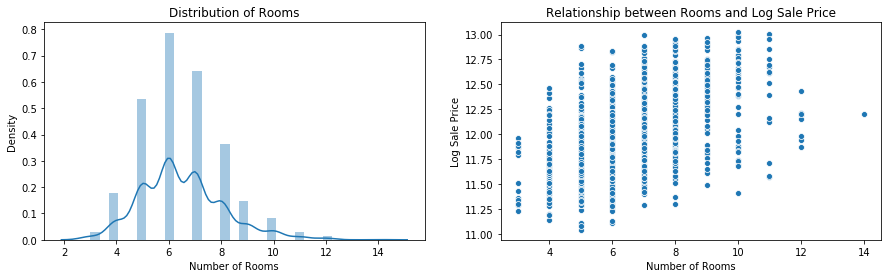

In [24]:
fig, (axis1, axis2) = plt.subplots(1,2, figsize = (15,4))

sns.distplot(df2['totrmsabvgrd'], ax = axis1)
sns.scatterplot(x = 'totrmsabvgrd', y = 'log_saleprice', data = df2, ax = axis2)

axis1.set_xlabel('Number of Rooms')
axis2.set_xlabel('Number of Rooms')

axis1.set_ylabel('Density')
axis2.set_ylabel('Log Sale Price')

axis1.set_title("Distribution of Rooms")
axis2.set_title("Relationship between Rooms and Log Sale Price")

##### 2.2.7 - Fireplaces 
The number of fireplaces ranges from 0 to 3, with most homes having either 0 or 1 fireplaces.  These are all reasonable numbers.  The general trend shows that with more fireplaces, the higher the sale price is.  

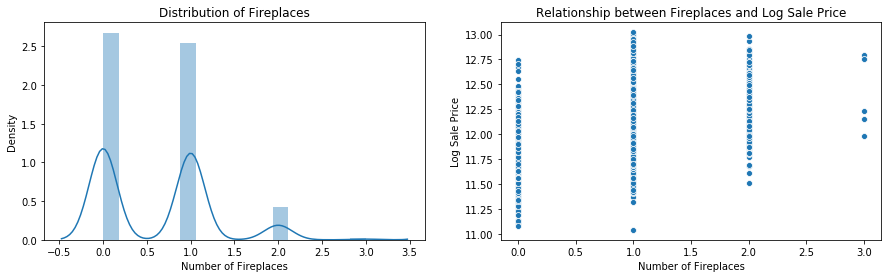

In [25]:
fig, (axis1, axis2) = plt.subplots(1,2, figsize = (15,4))

sns.distplot(df2['fireplaces'], ax = axis1)
sns.scatterplot(x = 'fireplaces', y = 'log_saleprice', data = df2, ax = axis2)

axis1.set_xlabel('Number of Fireplaces')
axis2.set_xlabel('Number of Fireplaces')

axis1.set_ylabel('Density')
axis2.set_ylabel('Log Sale Price')

axis1.set_title("Distribution of Fireplaces")
axis2.set_title("Relationship between Fireplaces and Log Sale Price")

##### 2.2.8 - Garage 
There are three features related to the garage: 1) year it was built, 2) how many cars it can hold, and 3) square feet of the garage.   

Its interesting to see that for the year the garage was built, we see a left skewed distribution instead, indicating that garages are more of a modern amenity.  Nevertheless, there are 72 homes without a garage (expressed as missing values), which were built anywhere between 1872 to 2007.  This is indicated as a 0 in the second and third distribution, where 0 cars can fit and there are 0 square footage dedicated to the garage.  Aside from that, most garages can fit 2 cars and have ~500 sqft.  As for the missing values in year garage was built, I want to see how deleting the rows with missing values vs filling them in would affect the model.  This step will be done in the modeling section.

For the log of the sale price, prices seem relatively steady until 1980, then the price goes up.  Meanwhile, the sale prices also increases if the garage can hold more cars or has more square footage.  

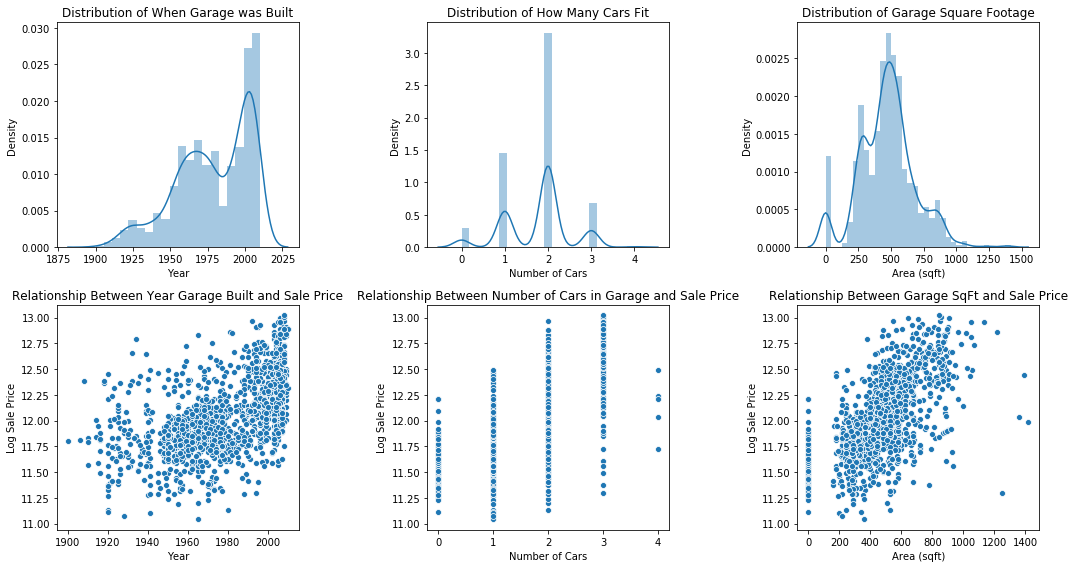

In [26]:
fig, ((axis1, axis2, axis3),(axis4, axis5, axis6)) = plt.subplots(2,3, figsize = (15,8))

sns.distplot(df2[df2['garageyrblt'].notnull()]['garageyrblt'], bins=20, ax = axis1)
sns.distplot(df2['garagecars'], ax = axis2)
sns.distplot(df2['garagearea'], ax = axis3)
sns.scatterplot(x = 'garageyrblt', y = 'log_saleprice', data = df2, ax = axis4)
sns.scatterplot(x = 'garagecars', y = 'log_saleprice', data = df2, ax = axis5)
sns.scatterplot(x = 'garagearea', y = 'log_saleprice', data = df2, ax = axis6)

axis1.set_title('Distribution of When Garage was Built')
axis2.set_title('Distribution of How Many Cars Fit')
axis3.set_title('Distribution of Garage Square Footage')
axis4.set_title('Relationship Between Year Garage Built and Sale Price')
axis5.set_title('Relationship Between Number of Cars in Garage and Sale Price')
axis6.set_title('Relationship Between Garage SqFt and Sale Price')

axis1.set_xlabel('Year')
axis2.set_xlabel('Number of Cars')
axis3.set_xlabel('Area (sqft)')
axis4.set_xlabel('Year')
axis5.set_xlabel('Number of Cars')
axis6.set_xlabel('Area (sqft)')

for ax in [axis1, axis2, axis3]:
    ax.set_ylabel('Density')
for ax in [axis4, axis5, axis6]:
    ax.set_ylabel('Log Sale Price')
plt.tight_layout()

#### 2.3 - Categorical Features
At the moment, categorical features are objects and I cannot get a correlation matrix when the categorical features are in string format.  One way to deal with this is to one hot encode the variables, but this can increase dimensionality very quickly.  Another way is to convert all the objects into categories and pandas can automatically convert the categorical features to numbers.  Once converted, I can get the correlations and thus, the correlation matrix and proceed similarly to how I did with numerical features.  This conversion to category codes is permanent to my knowledge, so I will create a copy of the dataframe called 'tmp' and convert the tmp variables.

In [27]:
cat_col = [col for col in df2.columns if df2[col].dtype == 'object']

In [28]:
tmp = df2.copy()

In [29]:
for col in cat_col:
    tmp[col] = tmp[col].astype('category')
    tmp[col] = tmp[col].cat.codes

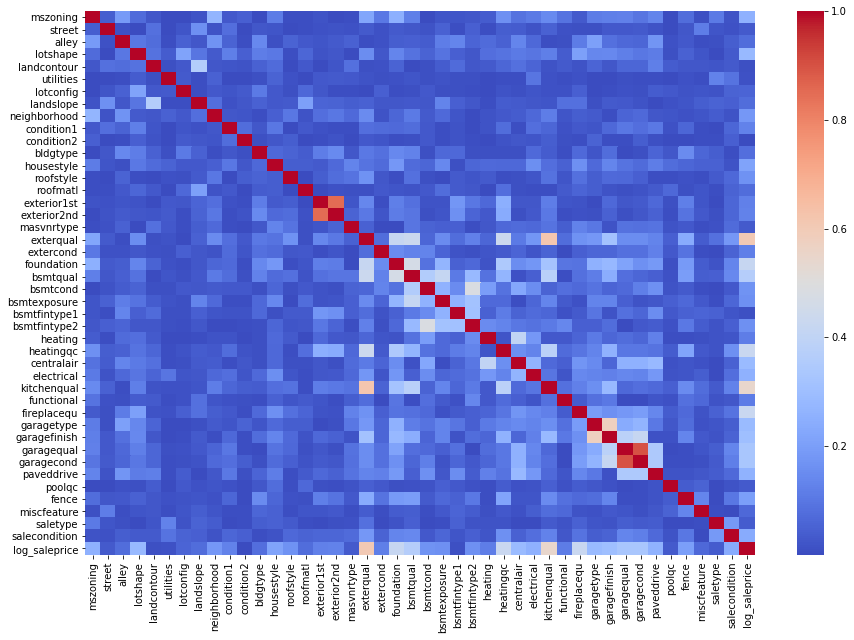

In [30]:
fig, axis1 = plt.subplots(1,1, figsize = (15,10))

sns.heatmap(np.absolute(pd.concat([tmp[cat_col], tmp['log_saleprice']], axis = 1).corr()), cmap = 'coolwarm')

Again, the features that are highly correlated to the log of sale prices are some shade of red in the last row.  From this matrix, it seems that the features I'm looking for are 'exterqual' and 'kitchenqual'.  Luckily, there are no missing values.  

Below I've also found categorical features that are moderately correlated with log sale price.  Just in case.

In [31]:
for col in tmp[cat_col].columns:
    corr = np.absolute(tmp[[col, 'log_saleprice']].corr()['log_saleprice'][0])
    if corr > 0.35:
        print('{} has corelation of {} with log sale price'.format(col, corr))

exterqual has corelation of 0.6059494814259272 with log sale price
foundation has corelation of 0.418454466121343 with log sale price
bsmtqual has corelation of 0.3655433509717203 with log sale price
heatingqc has corelation of 0.42769516141895647 with log sale price
kitchenqual has corelation of 0.5437656733355043 with log sale price
fireplacequ has corelation of 0.42957294067945745 with log sale price


In [32]:
cat_important = ['exterqual', 'kitchenqual']

In [33]:
cat_moderate = ['foundation', 'bsmtqual', 'heatingqc', 'fireplacequ']

In [34]:
# Any missing values?
for col in cat_important:
    if df2[col].isnull().sum() > 0:
        print(col)

##### 2.3.1 - External Quality
The external quality feature rates the quality of the exterior material.  The order of quality is poor (Po), fair (Fa), typical (TA), good (Gd) and excellent (Ex).  Most of the houses have an exterior quality of typical, and second are rated good.  As the quality of the exterior increases, the sale price also increases.  

In [35]:
qual_order = ['Fa', 'TA', 'Gd', 'Ex']

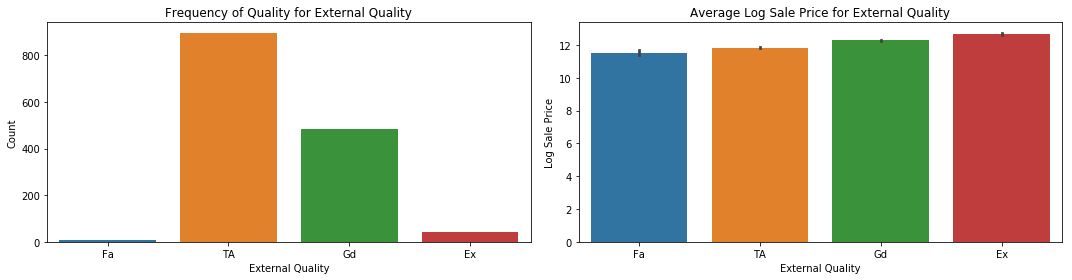

In [36]:
fig, (axis1, axis2) = plt.subplots(1,2, figsize = (15,4))

sns.countplot(x = 'exterqual', order = qual_order, data = df2, ax = axis1)
sns.barplot(x = 'exterqual', y = 'log_saleprice', order = qual_order, data = df2, ax = axis2)

axis1.set_title('Frequency of Quality for External Quality')
axis2.set_title('Average Log Sale Price for External Quality')

for ax in [axis1, axis2]:
    ax.set_xlabel('External Quality')
    
axis1.set_ylabel('Count')
axis2.set_ylabel('Log Sale Price')

plt.tight_layout()

##### 2.3.2 - Kitchen Quality
The kitchen quality has the same quality specifications as external quality.  Its results are similar to external quality, where most houses have a kitchen rating of typical and good, and as quality improves, the log sale prices also increases.  

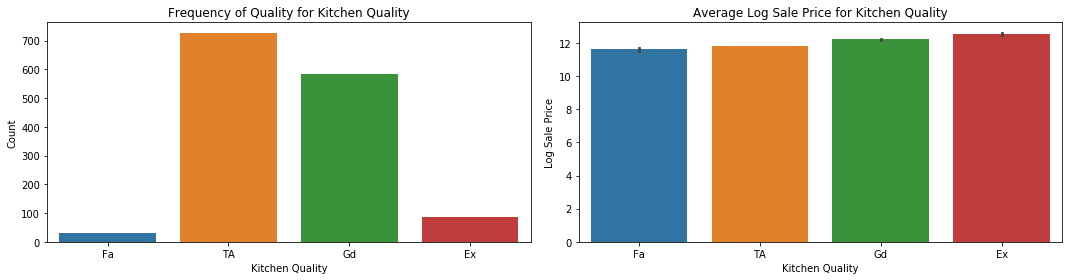

In [37]:
fig, (axis1, axis2) = plt.subplots(1,2, figsize = (15,4))

sns.countplot(x = 'kitchenqual', order = qual_order, data = df2, ax = axis1)
sns.barplot(x = 'kitchenqual', y = 'log_saleprice', order = qual_order, data = df2, ax = axis2)

axis1.set_title('Frequency of Quality for Kitchen Quality')
axis2.set_title('Average Log Sale Price for Kitchen Quality')

for ax in [axis1, axis2]:
    ax.set_xlabel('Kitchen Quality')
    
axis1.set_ylabel('Count')
axis2.set_ylabel('Log Sale Price')

plt.tight_layout()

### 3 - Feature Engineering
I alluded to this earlier, something that can benefit a regression model is to one hot encode categorical features.   Since there are only 2 categorical features, each with 4 unique values, dimensionality issues should not be a problem.

In [38]:
dummy_df = pd.DataFrame()

In [39]:
for col in cat_important:
    dummy_df = pd.concat([dummy_df, pd.get_dummies(df2[col], prefix = col, drop_first=True)], axis = 1)

### 4 - First Model
With data exploration, data cleaning, and feature engineering done, its time to prep the data for the first model!  First, I need to create a new dataframe that includes the important and one hot encoded features.  This gives us a dataframe with 18 features and 1 target variable, much smaller than the original dataset of 82 columns.

In [40]:
df3 = pd.concat([df2[num_important], dummy_df, df2['log_saleprice']], axis=1)

In [41]:
df3.shape

(1432, 19)

Also, remember those pesky missing values in the year garage was built?  I'll create three different dataframes here, one that removes the missing years, one that fills them in with the year the house was built, and one that fills them in with 0. 

There are pros and cons to each method, which is why I wanted to explore each one.  With removing the missing years, its possible the model will increase, but it also removes ~5% of the data.  However, at the moment I really can't think of a good value to impute.  Imputing the year the house was built is misleading since there is no garage.  I can impute a number far away from the current range to indicate it is different, but then this value is nonsensical.  

In [42]:
# Missing garageyrblt removed
df3_delgarage = df3.copy()
df3_delgarage = df3_delgarage[df3_delgarage['garageyrblt'].notnull()]

# Missing garageyrblt filled with year house built
df3_garagefillyr = df3.copy()
df3_garagefillyr['garageyrblt'] = df3_garagefillyr['garageyrblt'].fillna(tmp['yearbuilt'])

# Missing garageyrblt filled with 0
df3_garagefill0 = df3.copy()
df3_garagefill0['garageyrblt'] = df3_garagefill0['garageyrblt'].fillna(0)

#### 4.1 - Splitting into Training and Test Sets
Next, I need to identify which is the target variable (y) and the features (X) so I can split the data into training and tests sets to check for overfitting. I will use sklearn's 'train_test_split' function for this.

In [43]:
y_delgarage = df3_delgarage['log_saleprice']
X_delgarage = df3_delgarage.drop('log_saleprice', axis = 1)

y_garagefillyr = df3_garagefillyr['log_saleprice']
X_garagefillyr = df3_garagefillyr.drop('log_saleprice', axis = 1)

y_garagefill0 = df3_garagefill0['log_saleprice']
X_garagefill0 = df3_garagefill0.drop('log_saleprice', axis = 1)

In [44]:
X_delgarage_train, X_delgarage_test, y_delgarage_train, y_delgarage_test = train_test_split(X_delgarage, 
                                                                                            y_delgarage, 
                                                                                            test_size=0.2, random_state=42)

X_garagefillyr_train, X_garagefillyr_test, y_garagefillyr_train, y_garagefillyr_test = train_test_split(X_garagefillyr, 
                                                                                            y_garagefillyr, 
                                                                                            test_size=0.2, random_state=42)

X_garagefill0_train, X_garagefill0_test, y_garagefill0_train, y_garagefill0_test = train_test_split(X_garagefill0, 
                                                                                            y_garagefill0, 
                                                                                            test_size=0.2, random_state=42)

#### 4.2 - First Linear Regression Models
The first type of model I will apply is OLS.  The results of the three datasets are summarized in a table below.  The first dataset is where the missing values are removed from the dataset, the second is where the missing values are imputed with the year the house was built, and the third is where the missing values are imputed with 0.  

|  Model  |  R-squared  |  Adj R-squared  |  F-stat & p-value  |  AIC  |  BIC  |
|-----|  -----|  -----|  -----|  -----|  
|  OLS - garageyrblt deleted missing values|  0.821|  0.817  |  271.5 & 0  |  -1021|  -926.5  |
|  OLS - garageyrblt impute with year|  0.821|  0.818  |  286.7 & 0  |  -945.3|  -849.5  |
|  OLS - garageyrblt impute with 0|  0.820|  0.815  |  285.5 & 0  |  -941.2|  -845.4  |

The model with the best (highest) adjusted R-squared value is the second one, at 0.818, which means ~82% of the variance in sale prices are explained by this model.  

For all three models, the f-statistics have a p-value below 0.05, which says that to some degree, the model is useful for explaining the log of sale prices.  Since in each model there is a subset of features of the other, then the value of the f-statistics can be compared.  Here, the higher f-statistic is better, and the second model again has the better value.  

Last are the AIC and BIC, where the lower the number the better.  In this case, the first model has lower values for AIC and BIC.  

If I had to choose the best model out of these three, I'd choose the second model.  Although values R-squared, f-statistic, and AIC and BIC are generally in the same range for the first two models, I'm hesitant to use a model that deletes so many missing values.  In addition, note that these are the performance metrics for the training set.  I expect some overfitting to occur compared to the test set.  

In [45]:
X_delgarage_train = sm.add_constant(X_delgarage_train)
X_delgarage_test = sm.add_constant(X_delgarage_test)

X_garagefillyr_train = sm.add_constant(X_garagefillyr_train)
X_garagefillyr_test = sm.add_constant(X_garagefillyr_test)

X_garagefill0_train = sm.add_constant(X_garagefill0_train)
X_garagefill0_test = sm.add_constant(X_garagefill0_test)

In [46]:
results_delgarage = sm.OLS(y_delgarage_train, X_delgarage_train).fit()
print(results_delgarage.summary())

                            OLS Regression Results                            
Dep. Variable:          log_saleprice   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     271.5
Date:                Sun, 22 Sep 2019   Prob (F-statistic):               0.00
Time:                        22:01:47   Log-Likelihood:                 529.65
No. Observations:                1088   AIC:                            -1021.
Df Residuals:                    1069   BIC:                            -926.5
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              4.9612      0.734      6.

In [47]:
results_garagefillyr = sm.OLS(y_garagefillyr_train, X_garagefillyr_train).fit()
print(results_garagefillyr.summary())

                            OLS Regression Results                            
Dep. Variable:          log_saleprice   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     286.7
Date:                Sun, 22 Sep 2019   Prob (F-statistic):               0.00
Time:                        22:01:47   Log-Likelihood:                 491.65
No. Observations:                1145   AIC:                            -945.3
Df Residuals:                    1126   BIC:                            -849.5
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              5.0176      0.750      6.

In [48]:
results_garagefill0 = sm.OLS(y_garagefill0_train, X_garagefill0_train).fit()
print(results_garagefill0.summary())

                            OLS Regression Results                            
Dep. Variable:          log_saleprice   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     285.5
Date:                Sun, 22 Sep 2019   Prob (F-statistic):               0.00
Time:                        22:01:47   Log-Likelihood:                 489.61
No. Observations:                1145   AIC:                            -941.2
Df Residuals:                    1126   BIC:                            -845.4
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              4.4525      0.722      6.

##### 4.2.1 - Lasso, Ridge, and ElasticNet Regression
One last thing I wanted to try is to apply the second model to Lasso, Ridge, and ElasticNet regression.  However, I found that no matter how many folds I used, the results did not change.  This is most likely due to having too little features, which I will address in a future section.

In [49]:
alpha_lst = [10**int(i) for i in np.arange(-30, 30, 2)]

In [50]:
for i in np.arange(2,5):
    tmp = LassoCV(alphas=alpha_lst, cv = i)
    tmp.fit(X_garagefillyr_train, y_garagefillyr_train)
    tmp_preds = tmp.predict(X_garagefillyr_train)
    print(tmp.score(X_garagefillyr_train, y_garagefillyr_train))

0.809768231331
0.809768231331
0.809768231331


### 5 - Improving the Model


#### 5.1 - Adding Features
One way to improve the model (and which the more advanced regression techniques suggests) is to add more features.  Earlier, in section 2.3, I pointed out there were a few categorical features that were moderately correlated to the log of the sale price and noted them.  I will now add them to the dataset.  Before that though, I need to fill in the missing values for basement and fireplace quality.  In this case, the values are missing because there is no basement or fireplace.  I will impute the strings 'No_bsmt' and 'No_fireplace' respectively.  

In [51]:
df2['bsmtqual'] = df2['bsmtqual'].fillna('No_bsmt')

In [52]:
df2['fireplacequ'] = df2['fireplacequ'].fillna('No_fireplace')

I can now create dummy variables of the moderately correlated categorical features and add them to the dataframe.  In this case, I've made a new dataframe called df4.  I've also imputed the missing values of the year the garage built with the year the house was built.

In [53]:
for col in cat_moderate:
    dummy_df = pd.concat([dummy_df, pd.get_dummies(df2[col], prefix = col, drop_first=True)], axis = 1)

In [54]:
df4 = pd.concat([df2[num_important], dummy_df, df2['log_saleprice']], axis=1)

In [55]:
df4['garageyrblt'] = df4['garageyrblt'].fillna(df4['yearbuilt'])

Other features that might be of interest are ratios of square footage between the first floor:basement and first floor:living area as well as subtracting the year the house was remodeled to the year it was built as well as how long ago the remodel was (if any) to the time the house was sold.

In [56]:
df4['ratio_ff_bsmt'] = df4['totalbsmtsf'] / df4['firstflrsf'] 
df4['ratio_ff_grlivarea'] = df4['grlivarea'] / df4['firstflrsf']
df4['is_remodeled'] = df4['yearremodadd'] - df4['yearbuilt']

In [57]:
tmp = pd.concat([df4['yearremodadd'], df['yrsold']], join = 'inner', axis = 1)
tmp['remodel_to_sold'] = tmp['yrsold'] - tmp['yearremodadd']
df4 = pd.concat([df4, tmp['remodel_to_sold']], axis = 1)

The last ratio I'd like to add is the ratio of number of rooms to number of baths.

In [58]:
df4['ratio_bath_rooms'] = df4['fullbath'] / df4['totrmsabvgrd']

#### 5.2 - Improved OLS
It is immediately apparent that with the improved OLS model (called OLS-Improved), the R-squared value have risen, from ~0.821 to 0.839, and a similar increase for the adjusted R-squared value.  However, there are quite a few coefficients with large p-values (p-value > 0.05).  These coefficients with large p-values are likely to be zero in the real population.  Removing them can improve the model, or at the very least reduce noise in the model.  

In [59]:
X_improved = df4.drop(['log_saleprice'], axis = 1)
Y_improved = df4['log_saleprice']

X_improved_train, X_improved_test, y_improved_train, y_improved_test = train_test_split(X_improved, Y_improved, test_size = 0.2, random_state = 42)

X_improved_train = sm.add_constant(X_improved_train)
X_improved_test = sm.add_constant(X_improved_test)

results_improved  = sm.OLS(y_improved_train, X_improved_train).fit()
print(results_improved.summary())

                            OLS Regression Results                            
Dep. Variable:          log_saleprice   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     143.7
Date:                Sun, 22 Sep 2019   Prob (F-statistic):               0.00
Time:                        22:01:50   Log-Likelihood:                 552.12
No. Observations:                1145   AIC:                            -1022.
Df Residuals:                    1104   BIC:                            -815.5
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

The model that drops the coefficients with high p-values is below.  I will call this model OLS - Improved with dropped coeff.

In [69]:
X_improveddropped = df4.drop(['log_saleprice', 'yearremodadd', 'exterqual_Fa', 'exterqual_Gd', 'exterqual_TA',
                      'kitchenqual_Gd', 'foundation_Slab', 'foundation_Stone', 'foundation_Wood', 
                      'heatingqc_Gd', 'fireplacequ_Fa', 'fireplacequ_Gd', 'fireplacequ_TA', 'is_remodeled',
                      'remodel_to_sold'], axis = 1)
Y_improveddropped = df4['log_saleprice']

X_improveddropped_train, X_improveddropped_test, y_improveddropped_train, y_improveddropped_test = train_test_split(X_improveddropped, Y_improveddropped, test_size = 0.2, random_state = 42)

X_improveddropped_train = sm.add_constant(X_improveddropped_train)
X_improveddropped_test = sm.add_constant(X_improveddropped_test)

results_improveddropped  = sm.OLS(y_improveddropped_train, X_improveddropped_train).fit()
print(results_improveddropped.summary())

                            OLS Regression Results                            
Dep. Variable:          log_saleprice   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     207.2
Date:                Sun, 22 Sep 2019   Prob (F-statistic):               0.00
Time:                        23:04:49   Log-Likelihood:                 533.69
No. Observations:                1145   AIC:                            -1011.
Df Residuals:                    1117   BIC:                            -870.2
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

The results of all the models so far is summarized in the table below.  After removing the coefficients with high p-values, the R- and adjusted R-squared values diminished slightly compared to the OLS - Improved.  However, F-statistics, AIC, and BIC all see an improvement after the coefficients were dropped.  

Out of all the models tested so far, the model with the dropped coefficients is the best.  

|  Model  |  R-squared  |  Adj R-squared  |  F-stat & p-value  |  AIC  |  BIC  |
|-----|  -----|  -----|  -----|  -----|  
|  OLS - garageyrblt deleted missing values|  0.821|  0.817  |  271.5 & 0  |  -1021|  -926.5  |
|  OLS - garageyrblt impute with year|  0.821|  0.818  |  286.7 & 0  |  -945.3|  -849.5  |
|  OLS - garageyrblt impute with 0|  0.820|  0.815  |  285.5 & 0  |  -941.2|  -845.4  |
|  OLS - Improved  |  0.839|  0.833  |  143.7 & 0  |  -1022.0|  -815.5  |
|  OLS - Improved with dropped coeff  |  0.834|  0.830  |  207.2 & 0  |  -1011.0|  -870.2  |


#### 5.3 More Advanced Regression Models
How does the improved OLS model compare to more advanced regression algorithms such as Lasso, Ridge, and Elasticnet?  Below I've plotted each model according to number of cross validation folds.  In this case, I only tested out 3, 5, and 10 folds.  

In [61]:
# Lasso Regression
lasso_lst = []
for i in [3, 5, 10]:
    tmp = LassoCV(alphas=alpha_lst, cv = i)
    tmp.fit(X_improved_train, y_improved_train)
    tmp_preds = tmp.predict(X_improved_train)
    lasso_lst.append(tmp.score(X_improved_train, y_improved_train))
    
# Ridge Regression
ridge_lst = []
for i in [3, 5, 10]:
    tmp = RidgeCV(alphas=alpha_lst, cv = i)
    tmp.fit(X_improved_train, y_improved_train)
    tmp_preds = tmp.predict(X_improved_train)
    ridge_lst.append(tmp.score(X_improved_train, y_improved_train))
    
# ElasticNet Regression
elasticnet_lst = []
for i in [3, 5, 10]:
    tmp = ElasticNetCV(alphas=alpha_lst, cv = i)
    tmp.fit(X_improved_train, y_improved_train)
    tmp_preds = tmp.predict(X_improved_train)
    elasticnet_lst.append(tmp.score(X_improved_train, y_improved_train))

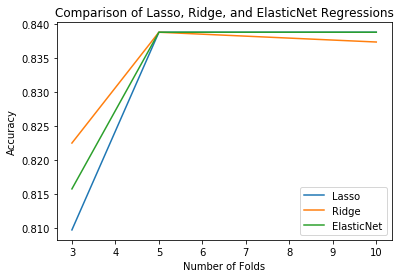

In [62]:
plt.plot([3, 5, 10], lasso_lst)
plt.plot([3, 5, 10], ridge_lst)
plt.plot([3, 5, 10], elasticnet_lst)

plt.legend(['Lasso', 'Ridge', 'ElasticNet'])
plt.xlabel('Number of Folds')
plt.ylabel('Accuracy')
plt.title('Comparison of Lasso, Ridge, and ElasticNet Regressions')

For all three models, it looks like 5 is the best number of folds, with the Ridge regression having the highest accuracy, although all three models are very close in accuracy when there are 5 folds.  

In [65]:
np.argmax([lasso_lst[1], ridge_lst[1], elasticnet_lst[1]])

1

#### 5.3 - Applying the Best Model to Test Set
So first off, which one is the best model to use?  Right now, its between OLS (the improved version with dropped coefficients) and Ridge Regression.  Lets expand from looking at R-squared values and look at errors.  For OLS and Ridge regressions, I will look at the R-squared values for training and test sets, the mean absolute error, mean squared error, root mean squared error, and mean absolute percentage error.  The errors are applied on the test results, and the Ridge regression will not drop coefficients.

In [70]:
# OLS model
lrm_improveddropped = LinearRegression()
lrm_improveddropped.fit(X_improveddropped_train, y_improveddropped_train)

y_lrm_improveddropped_train = lrm_improveddropped.predict(X_improveddropped_train)
y_lrm_improveddropped_test = lrm_improveddropped.predict(X_improveddropped_test)

In [72]:
print("R-squared of the OLS model on the training set is: {}".format(lrm_improveddropped.score(X_improveddropped_train, y_improveddropped_train)))
print("-----Test set statistics-----")
print("R-squared of the OLS model on the test set is: {}".format(lrm_improveddropped.score(X_improveddropped_test, y_improveddropped_test)))
print("Mean absolute error of the OLS prediction is: {}".format(mean_absolute_error(y_improveddropped_test, y_lrm_improveddropped_test)))
print("Mean squared error of the OLS prediction is: {}".format(mse(y_improveddropped_test, y_lrm_improveddropped_test)))
print("Root mean squared error of the OLS prediction is: {}".format(rmse(y_improveddropped_test, y_lrm_improveddropped_test)))
print("Mean absolute percentage error of the OLS prediction is: {}".format(np.mean(np.abs((y_improveddropped_test - y_lrm_improveddropped_test) / y_improveddropped_test)) * 100))


R-squared of the OLS model on the training set is: 0.8335888768882482
-----Test set statistics-----
R-squared of the OLS model on the test set is: 0.8264738262283381
Mean absolute error of the OLS prediction is: 0.10330876212897935
Mean squared error of the OLS prediction is: 0.019128407069729795
Root mean squared error of the OLS prediction is: 0.13830548459742945
Mean absolute percentage error of the OLS prediction is: 0.8680379845673207


In [73]:
# Ridge model
ridge_improved = RidgeCV(alphas= alpha_lst, cv = 5)
ridge_improved.fit(X_improved_train, y_improved_train)

y_ridge_improved_train = ridge_improved.predict(X_improved_train)
y_ridge_improved_test = ridge_improved.predict(X_improved_test)

In [74]:
print("R-squared of the Ridge model on the training set is: {}".format(ridge_improved.score(X_improved_train, y_improved_train)))
print("-----Test set statistics-----")
print("R-squared of the Ridge model on the test set is: {}".format(ridge_improved.score(X_improved_test, y_improved_test)))
print("Mean absolute error of the Ridge prediction is: {}".format(mean_absolute_error(y_improved_test, y_ridge_improved_test)))
print("Mean squared error of the Ridge prediction is: {}".format(mse(y_improved_test, y_ridge_improved_test)))
print("Root mean squared error of the Ridge prediction is: {}".format(rmse(y_improved_test, y_ridge_improved_test)))
print("Mean absolute percentage error of the Ridge prediction is: {}".format(np.mean(np.abs((y_improved_test - y_ridge_improved_test) / y_improved_test)) * 100))


R-squared of the Ridge model on the training set is: 0.8388600077849128
-----Test set statistics-----
R-squared of the Ridge model on the test set is: 0.8316675495151729
Mean absolute error of the Ridge prediction is: 0.10249993261215583
Mean squared error of the Ridge prediction is: 0.018555884486659194
Root mean squared error of the Ridge prediction is: 0.13621998563595283
Mean absolute percentage error of the Ridge prediction is: 0.861259163371256


Although the R-squared value of the training set are similar for the OLS and Ridge models, the R-squared values for the test set is higher for the Ridge model.  In addition, the Ridge model has slightly better values for each type of error.  Overall, the Ridge model does better than OLS.

### 6 - Introducing External Sources
This dataset is comprehensive when it comes to information about the house, its features, and the land it sits on.  While these are very important in determining house prices, we all know that economic factors also play a huge role, as the cyclical nature of housing cycles remind us every decade or so (remember that housing bust of 2008?).  Two external sources I feel would improve the model are mortgage rates and median income levels for Story county, where Ames is located.  The mortgage rate data is taken from [Freddie Mac's website](http://www.freddiemac.com/pmms/pmms30.html) and uses the 30 year fixed mortgage rate since that is the most common type of mortgage to take out.  The income data is taken from [Iowa's data center website](https://www.iowadatacenter.org/data/saipe/saipe-income).

#### 6.1 - Getting the Date
The first step to applying the mortgage rates and income to the data set is to get the month and year the house was sold.  This information is available in the original dataset.  I've put it in a month/year format and added it to my latest dataset. The earliest house sold is January 2006 and the latest is July 2010.

In [78]:
tmp = pd.DataFrame(columns = ['date'])
def get_date(cols):
    month = str(cols[0])
    year = str(cols[1])
    return month + '/' + year

tmp['date'] = df[['mosold', 'yrsold']].apply(get_date, axis = 1)

In [79]:
df4 = pd.concat([df4, tmp], axis = 1,join = 'inner' )

#### 6.2 - Adding Mortgage Rate and Income
Mortgage rates change daily, so these values reflect the monthly average.  Income is taken on a yearly basis.  

In [80]:
mortgage_dict = {'1/2006': 6.15, '2/2006': 6.25, '3/2006': 6.32, '4/2006': 6.51, '5/2006': 6.60, '6/2006': 6.68, '7/2006': 6.76,
                 '8/2006': 6.52, '9/2006': 6.40, '10/2006': 6.36, '11/2006': 6.24, '12/2006': 6.14, '1/2007': 6.22,
                 '2/2007': 6.29, '3/2007': 6.16, '4/2007': 6.18, '5/2007': 6.26, '6/2007': 6.66, '7/2007': 6.70, '8/2007': 6.57,
                 '9/2007': 6.38, '10/2007': 6.38, '11/2007': 6.21, '12/2007': 6.10, '1/2008': 5.76, '2/2008': 5.92, 
                 '3/2008': 5.97, '4/2008': 5.92, '5/2008': 6.04, '6/2008': 6.32, '7/2008': 6.43, '8/2008': 6.48, '9/2008': 6.04,
                 '10/2008': 6.20, '11/2008': 6.09, '12/2008': 5.29, '1/2009': 5.05, '2/2009': 5.13, '3/2009': 5.00, 
                 '4/2009': 4.81, '5/2009': 4.86, '6/2009': 5.42, '7/2009': 5.22, '8/2009': 5.19, '9/2009': 5.06,
                 '10/2009': 4.95, '11/2009': 4.88, '12/2009': 4.93, '3/2010': 4.97, '5/2010': 4.89, '1/2010': 5.03,
                '7/2010': 4.56, '6/2010': 4.74, '4/2010': 5.10, '2/2010': 4.99}

In [81]:
income_dict = {2006: 44698, 2007: 49104, 2008: 50265, 2009: 48165, 2010: 49192}

In [82]:
df4['mortgage'] = df4['date'].apply(lambda x: mortgage_dict[x])
df4['income'] = df4['date'].apply(lambda x: income_dict[int(x.split('/')[1])])

#### 6.3 - The Model with Economic Factors
A table that summarizes the R-squared values and errors for the Ridge models with the 'improved' dataset and 'economic' dataset is below.  By all accounts, the model with the economic factors performed slightly better than then improved Ridge model, as the R- and adjusted R-squared scores are higher, and the error scores are lower compared to the model without economic factors.  

|  Model  |  R-squared Training  |  R-squared Test  | MAE  |  MSE  |  RMSE  |  MAPE  |
|-----|  -----|  -----|  -----|  -----|  
|  Ridge - Improved  |  0.839| 0.832  |   0.102  |  0.019|  0.136  |  0.861  |
|  OLS - Economics  |  0.840| 0.834  |   0.101  |  0.018|  0.135  |  0.853  |

In [83]:
X_econ = df4.drop(['log_saleprice', 'date'], axis = 1)
Y_econ = df4['log_saleprice']

X_econ_train, X_econ_test, y_econ_train, y_econ_test = train_test_split(X_econ, Y_econ, test_size = 0.2, random_state = 42)

In [86]:
# Ridge model
ridge_econ = RidgeCV(alphas= alpha_lst, cv = 5)
ridge_econ.fit(X_econ_train, y_econ_train)

y_ridge_econ_train = ridge_econ.predict(X_econ_train)
y_ridge_econ_test = ridge_econ.predict(X_econ_test)

In [87]:
print("R-squared of the econ model on the training set is: {}".format(ridge_econ.score(X_econ_train, y_econ_train)))
print("-----Test set statistics-----")
print("R-squared of the econ model on the test set is: {}".format(ridge_econ.score(X_econ_test, y_econ_test)))
print("Mean absolute error of the econ prediction is: {}".format(mean_absolute_error(y_econ_test, y_ridge_econ_test)))
print("Mean squared error of the econ prediction is: {}".format(mse(y_econ_test, y_ridge_econ_test)))
print("Root mean squared error of the econ prediction is: {}".format(rmse(y_econ_test, y_ridge_econ_test)))
print("Mean absolute percentage error of the econ prediction is: {}".format(np.mean(np.abs((y_econ_test - y_ridge_econ_test) / y_econ_test)) * 100))


R-squared of the econ model on the training set is: 0.8384878442767291
-----Test set statistics-----
R-squared of the econ model on the test set is: 0.8369327163485838
Mean absolute error of the econ prediction is: 0.10087124148458568
Mean squared error of the econ prediction is: 0.017975486427447382
Root mean squared error of the econ prediction is: 0.1340726908339181
Mean absolute percentage error of the econ prediction is: 0.8476379918155512


### 7 - Conclusion
This notebook explored the what factors affected sale prices of houses in Ames, Iowa between the years of 2004 and 2010.  To do so, I employed multiple types of linear regression models including OLS, Ridge, Lasso, and ElasticNet regression.  Through data cleaning, feature engineering, and statistical analysis, I found that the Ridge model had the best model with an R-squared value of 0.832 on the test set.  However, there are many external factors (i.g.  not related to the house) that affect the final selling price of a home.  In this case, I chose to explore the effects of mortgage rates and median income in Story County, the county where Ames is located in.  Adding these external economic factors to the Ridge model increased the R-squared values and decreased all the error rates compared to the model without the economic factors.  